To run this stuff, I will need a .wav file pathway of an instrumental.
Once these two blocks are done we will have a "start_time" and "end_time" variable which will represent the start and end of a beat in whatever .wav file we worked in.

In [1]:
def most_common_with_tolerance(values, tolerance):
    clusters = []

    for val in values:
        # Try to add it to an existing cluster
        for cluster in clusters:
            if abs(cluster['center'] - val) <= tolerance:
                cluster['values'].append(val)
                break
        else:
            # No cluster found, create a new one
            clusters.append({'center': val, 'values': [val]})

    # Find the cluster with the most values
    most_common_cluster = max(clusters, key=lambda c: len(c['values']))

    # Return the average of all original values in the most populated cluster
    return sum(most_common_cluster['values']) / len(most_common_cluster['values'])

In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate, find_peaks
import os

# 1. Load audio
y, sr = librosa.load(os.getcwd() + "/drive/MyDrive/UCI'25 Datathon Music Project/franchise_separated.wav", sr=None)    ## The name of file must go here
y, _ = librosa.effects.trim(y)

# 2. Autocorrelation
corr = correlate(y, y, mode='full')
corr = corr / np.max(corr)

# 3. Convert to time
lags = np.arange(-len(y) + 1, len(y))
lags_sec = lags / sr

# 4. Focus on positive lags
mid = len(corr) // 2
positive_corr = corr[mid:]
positive_lags_sec = lags_sec[mid:]

# 5. Ignore very short lags (e.g., under 1 sec)
min_lag_sec = 1.0
min_lag_idx = np.searchsorted(positive_lags_sec, min_lag_sec)

# 6. Find multiple peaks
peaks, properties = find_peaks(positive_corr[min_lag_idx:], height=0.1, distance=int(sr * .5))
peaks += min_lag_idx  # shift index

# 7. Get top N peaks (e.g., 5)
N = 11
peak_heights = properties["peak_heights"]
top_indices = np.argsort(peak_heights)[::-1][:N]
top_peaks = peaks[top_indices]
top_lags_sec = sorted(positive_lags_sec[top_peaks])

# 8. Display results
print("Calculating longest...")
difference_list = []
for i, lag in enumerate(top_lags_sec):
    if i==0: continue
    difference = round(top_lags_sec[i] - top_lags_sec[i - 1], 2)
    difference_list.append(difference)
loop_duration = round(most_common_with_tolerance(difference_list, .1), 2)
print(loop_duration)


for i in range(len(top_lags_sec)):
    for j in range(i+1, len(top_lags_sec)):
        delta = round(top_lags_sec[j] - top_lags_sec[i], 2)
        if abs(delta - loop_duration) <= .1:
            start_time = round(top_lags_sec[i], 2)
            end_time = round(top_lags_sec[j], 2)
            break
    if start_time is not None:
        break


Calculating longest...
3.1


The below technically isn't needed, but it's helpful to make sure that the above algorithm above worked correctly.

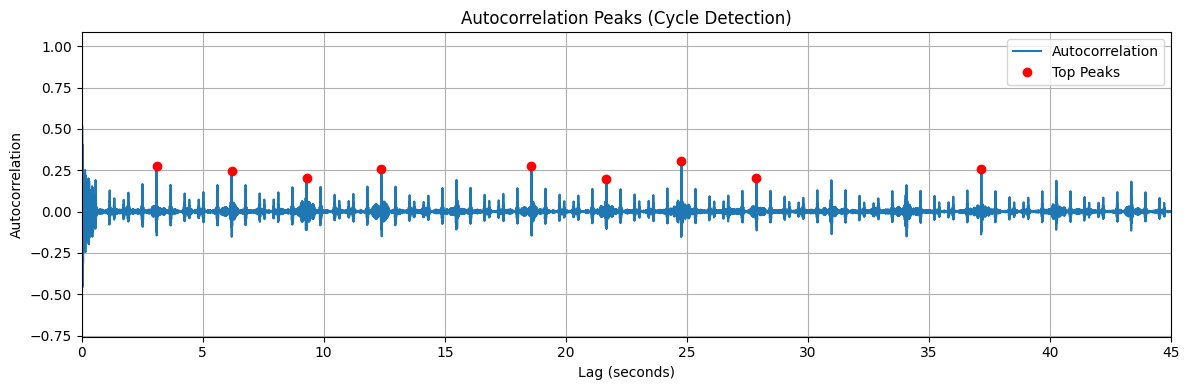

In [7]:
# This will graph it.
plt.figure(figsize=(12, 4))
plt.plot(positive_lags_sec, positive_corr, label='Autocorrelation')
plt.plot(positive_lags_sec[top_peaks], positive_corr[top_peaks], "ro", label="Top Peaks")
plt.xlabel("Lag (seconds)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation Peaks (Cycle Detection)")
plt.xlim(0, 45)  # You can increase this if needed
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
